In [1]:
# !pip install kaggle

In [2]:
# !mkdir ~/.kaggle

In [3]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# !kaggle competitions download -c idl-fall2021-hw1p2

In [5]:
# !unzip idl-fall2021-hw1p2.zip -d Data/

In [6]:
# !conda install matplotlib

# Global Settings

In [134]:
GLOBALTEST = False
TOY = True # TOY mode use smaller dataset
TRIALNUM = 4
STARTING_EPOCH = 0
MODEL_TO_LOAD = ""

In [135]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import torch.optim as optim

from torch.utils import data

%matplotlib inline

In [136]:
cuda = torch.cuda.is_available()
if cuda: print("Using cuda!!") 
else: print("No cuda available")

No cuda available


# Loading Data

In [137]:
real_paths = ["Data/train.npy", "Data/train_labels.npy", "Data/dev.npy", "Data/dev_labels.npy"]
toy_paths = ["Data/toy_train_data.npy", "Data/toy_train_label.npy", "Data/toy_val_data.npy", "Data/toy_val_label.npy"]

if TOY:
    paths = toy_paths
else:
    paths = real_paths
print(paths)
train_data = np.load(paths[0], allow_pickle=True)
train_label = np.load(paths[1], allow_pickle=True)
test_data = np.load(paths[2], allow_pickle=True)
test_label = np.load(paths[3], allow_pickle=True)

['Data/toy_train_data.npy', 'Data/toy_train_label.npy', 'Data/toy_val_data.npy', 'Data/toy_val_label.npy']


In [138]:
print(train_data.shape)
print(train_data[0].shape)

(1000,)
(1184, 40)


In [139]:
print(train_label.shape)
print(train_label[0].shape)

(1000,)
(1184,)


In [140]:
if TOY:
    train_data = train_data[:100]
    train_label = train_label[:100]
    test_data = test_data[:30]
    test_label = test_label[:30]

## Dataset

In [141]:
from dataset import MyDataset

## Dataloader

In [142]:
num_workers = 0 if cuda else 0 
context_size = 10

# Training
train_dataset = MyDataset(train_data, train_label, context_size = context_size)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
test_dataset = MyDataset(test_data, test_label, context_size = context_size)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

del train_data
del test_data
del train_label
del test_label

In [143]:
print(len(train_dataset))
# print(list(test_loader))

134105


# Model and Loss Function

In [144]:
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # print("x", x.shape)
        y = self.net(x)
        # print("y", y.shape)
        return self.softmax(y)

In [145]:
model = Simple_MLP([40*(2*context_size+1), 256, 128, 71])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 2e-4)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=840, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=71, bias=True)
  )
  (softmax): Softmax(dim=-1)
)


In [146]:
# testinput = torch.rand(32, 40*(2*context_size+1)).to(device)
# testoutput = model.forward(testinput)
# print(testoutput)
# print(sum(testoutput[0])) 
# print(testoutput[0].shape)

# Training Procedure

In [147]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [148]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [149]:
def save_model(model, epoch, loaded_model):
    folder = "Models/"
    if TOY:
        folder += "Toy/"
        torch.save(model.state_dict(), folder+"ToyTrial"+str(TRIALNUM)+"Epoch"+str(STARTING_EPOCH + epoch)+".pth")
    else:
        torch.save(model.state_dict(), folder+"Trial"+str(TRIALNUM)+"Epoch"+str(STARTING_EPOCH + epoch)+".pth")
def load_model(model, filename):
    if not filename:
        return
    state_dict = torch.load("Models/"+filename, map_location=torch.device(device))
    model.load_state_dict(state_dict)

## Training

In [150]:
n_epochs = 30
Train_loss = []
Test_loss = []
Test_acc = []

load_model(model, MODEL_TO_LOAD)

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    
    save_model(model, i+1, MODEL_TO_LOAD)
        
    print('='*20)

Training Loss:  4.076867174669986 Time:  10.198328733444214 s
Testing Loss:  4.084522799042697
Testing Accuracy:  20.205883060345865 %
Training Loss:  4.006042670657616 Time:  10.096734762191772 s
Testing Loss:  4.048118983850274
Testing Accuracy:  23.76313827356471 %
Training Loss:  3.9300887063714383 Time:  10.211688041687012 s
Testing Loss:  4.028250005099154
Testing Accuracy:  25.88209827548885 %
Training Loss:  3.9146701459211246 Time:  10.2035813331604 s
Testing Loss:  4.037654517306323
Testing Accuracy:  24.847872621882292 %
Training Loss:  3.895058386198437 Time:  10.1077880859375 s
Testing Loss:  4.019069672949768
Testing Accuracy:  26.687832214926523 %
Training Loss:  3.881747005550006 Time:  10.206326961517334 s
Testing Loss:  4.014255658984485
Testing Accuracy:  27.188108810159463 %
Training Loss:  3.8734196326659838 Time:  9.962157964706421 s
Testing Loss:  4.02263732179779
Testing Accuracy:  26.360728287274217 %
Training Loss:  3.865171265738611 Time:  10.354842901229858 

## Result Visualization

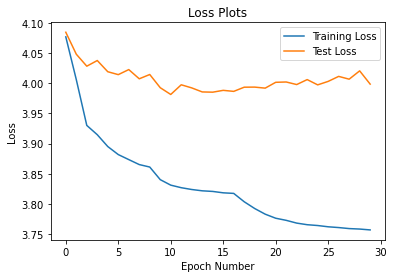

In [151]:
plt.title('Loss Plots')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss, label='Training Loss')
plt.plot(Test_loss, label = 'Test Loss')
plt.legend()

if TOY:
    plt.savefig('Graphs/Toy/'+'Trial'+str(TRIALNUM)+'LossPlots.png')
else:
    plt.savefig('Graphs/'+'Trial'+str(TRIALNUM)+'LossPlots.png')

plt.show()

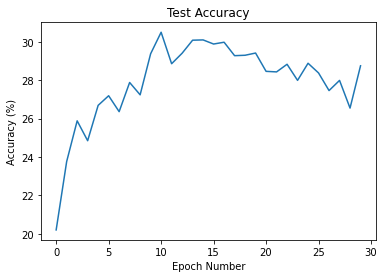

In [152]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

if TOY:
    plt.savefig('Graphs/Toy/'+'Trial'+str(TRIALNUM)+'Accuracy.png')
else:
    plt.savefig('Graphs/'+'Trial'+str(TRIALNUM)+'Accuracy.png')

plt.show()